# Определение перспективного тарифа для телеком-компании
## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: Смарт и Ультра. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
**Описание тарифов**
**Тариф Смарт:**

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф Ультра:**

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
*Обратите внимание: «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*


### Описание данных

**Таблица users (информация о пользователях):**

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то - со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# Шаг 1. Ознакомление с данными и их обработка

In [2]:
#Загрузим данные
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

### Посомтрим общие данные и почистим их

#### Начнем с users

In [3]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [4]:
#проверим, все ли пользователи уникальные
print("Число строк в датафрейме users:", users.shape[0])
print("Число уникальных пользователей:", users['user_id'].count())
print("Число дубликатов:", users.duplicated().sum())

Число строк в датафрейме users: 500
Число уникальных пользователей: 500
Число дубликатов: 0


In [5]:
#Посмотрим на пропуски:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски только в столбце `churn_date`, причем их довольно много. Смотрим описание задачи - там сказано:
*`churn_date` - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).*
Оставим данные в этом столбце как есть - для решения поставленной задачи они нам не нужны.

**Вывод**

Необходимо изменить тип данных:
- reg_date - на datetime.

Необходимо добавить следующие столбцы:
- месяц;
- время года.

#### Посмотрим таблицу calls

In [6]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Вывод**
Данные полные, без пропусков.

Необходимо изменить тип данных:

- call_date - на datetime.

Text(0, 0.5, 'Количество')

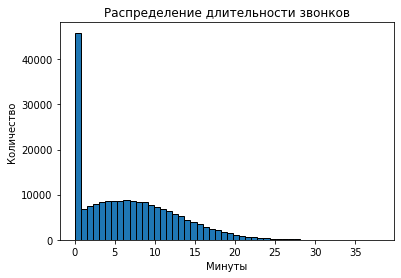

In [8]:
ax = calls['duration'].plot(kind='hist', ec='black', bins=50)
ax.set_title("Распределение длительности звонков")
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество')

*Обратите внимание: «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

In [10]:
#Округляем в большую сторону до минуты все звонки при помощи np.ceil
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Text(0, 0.5, 'Количество')

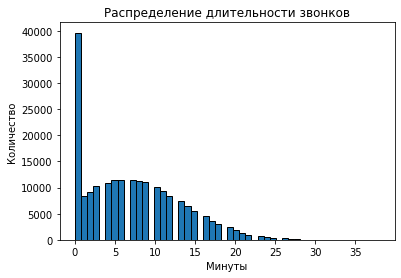

In [11]:
#Повторно посмотрим гистограмму после округления
ax = calls['duration'].plot(kind='hist', ec='black', bins=50)
ax.set_title("Распределение длительности звонков")
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество')

In [12]:
#Посмотрим сколько нулевых звонков
calls.query('duration == 0.0')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


Как видим их довольно много. Они не расходуют лимиты минут и вообще не принимают участия в формировании конечной выручки, удаляем эти строки

In [13]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

Text(0, 0.5, 'Количество')

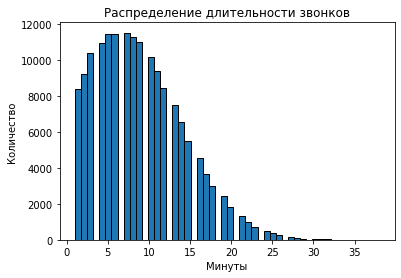

In [14]:
ax = calls['duration'].plot(kind='hist', ec='black', bins=50)
ax.set_title("Распределение длительности звонков")
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество')

#### Посмотрим таблицу messages

In [15]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Вывод**
Данные полные, без пропусков.

Необходимо изменить тип данных:

- message_date - на datetime.

#### Посмотрим таблицу internet

In [17]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**Вывод**
Данные полные без пропусков

Необходимо изменить тип данных:

- session_date - на datetime.

In [19]:
#Вспоминаем политику компании по округлению трафика до целых значений
#Округляем в большую сторону до мегабайта весь трафик по каждой сессии при помощи np.ceil
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000
3,3,1000_3,551.0,2018-08-22,1000
4,4,1000_4,303.0,2018-09-24,1000


Text(0, 0.5, 'Количество')

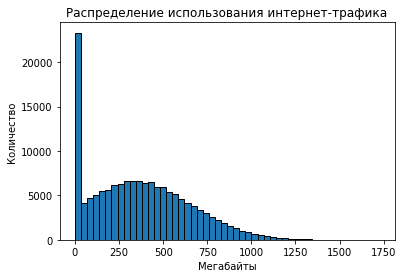

In [20]:
#Посмотрим на гистограмму распределения использования интернет-трафика
ax = internet['mb_used'].plot(kind='hist', ec='black', bins=50)
ax.set_title("Распределение использования интернет-трафика")
ax.set_xlabel('Мегабайты')
ax.set_ylabel('Количество')

In [21]:
#Также посмотрим на 'нулевые' строчки
internet.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


Их также довольно много! Также удаляем их.

In [22]:
#Исключили нулевые строки
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

Text(0, 0.5, 'Количество')

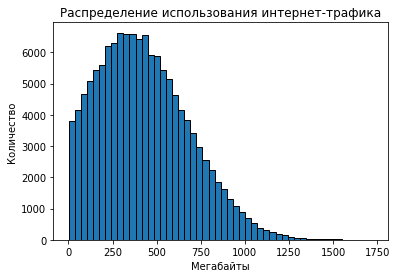

In [23]:
ax = internet['mb_used'].plot(kind='hist', ec='black', bins=50)
ax.set_title("Распределение использования интернет-трафика")
ax.set_xlabel('Мегабайты')
ax.set_ylabel('Количество')

#### Посмотрим таблицу tariffs

In [24]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
tariffs.info()
#Все ок

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


# Шаг 2. Подготовьте данные

### Изменение типа данных столбцов с датами и добавление столбцов "год", "месяц" и "время года" по каждому датафрейму

По каждой из таблиц есть столбцы, где необходимо изменить тип данных на "datetime"

In [26]:
# функция определения времени года
def get_season(date):
    if date.month in [1, 2, 12]:
        return 'зима'
    elif date.month in [3, 4, 5]:
        return 'весна'
    elif date.month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'
    
# столбец в формат datetime + добавление столбцов "месяц" и "время года"
def date_to_dt_month_season(dataframes):
    for df in dataframes:
        for column in df.columns:
            if 'date' in column and column != 'churn_date':
                df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
                df['месяц'] = df[column].apply(lambda x: x.month)
                df['время года'] = df[column].apply(get_season)

In [27]:
date_to_dt_month_season([users, calls, messages, internet])

In [28]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,месяц,время года
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,весна
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,осень
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,лето
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,лето
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,весна


In [29]:
calls.head()

,id,call_date,duration,user_id,месяц,время года
2,1000_2,2018-06-11,3.0,1000,6,лето
3,1000_3,2018-09-21,14.0,1000,9,осень
4,1000_4,2018-12-15,6.0,1000,12,зима
7,1000_7,2018-08-22,19.0,1000,8,лето
8,1000_8,2018-09-15,19.0,1000,9,осень


In [30]:
messages.head()

,id,message_date,user_id,месяц,время года
0,1000_0,2018-06-27,1000,6,лето
1,1000_1,2018-10-08,1000,10,осень
2,1000_2,2018-08-04,1000,8,лето
3,1000_3,2018-06-16,1000,6,лето
4,1000_4,2018-12-05,1000,12,зима


In [31]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,месяц,время года
0,0,1000_0,113.0,2018-11-25,1000,11,осень
1,1,1000_1,1053.0,2018-09-07,1000,9,осень
2,2,1000_2,1198.0,2018-06-25,1000,6,лето
3,3,1000_3,551.0,2018-08-22,1000,8,лето
4,4,1000_4,303.0,2018-09-24,1000,9,осень


In [32]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 7 columns):
Unnamed: 0      129798 non-null int64
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int64
месяц           129798 non-null int64
время года      129798 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 7.9+ MB


Все окей, даты стали датами)

### Посчитайте для каждого пользователя
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [33]:
# Возьмем из каждого имеющегося датафрейма нужные данные и склеим эти данные в один датафрейм
num_of_calls = calls.groupby(['user_id', 'время года', 'месяц'])['duration'].agg(['count', 'sum'])
num_of_messages = messages.groupby(['user_id', 'время года', 'месяц'])['id'].count()
num_of_internet = internet.groupby(['user_id', 'время года', 'месяц']).sum()['mb_used']

In [34]:
df_event_numbers = pd.concat([num_of_calls, num_of_messages, num_of_internet], axis=1)
df_event_numbers = df_event_numbers.reset_index()
df_event_numbers.head()

,user_id,время года,месяц,count,sum,id,mb_used
0,1000,весна,5,17.0,159.0,22.0,2256.0
1,1000,зима,12,38.0,333.0,70.0,9827.0
2,1000,лето,6,28.0,172.0,60.0,23257.0
3,1000,лето,7,41.0,340.0,75.0,14016.0
4,1000,лето,8,42.0,408.0,81.0,14070.0


In [36]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,месяц,время года
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,весна
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,осень
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,лето
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,лето
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,весна


In [37]:
df_event_numbers.head()

,user_id,время года,месяц,count,sum,id,mb_used
0,1000,весна,5,17.0,159.0,22.0,2256.0
1,1000,зима,12,38.0,333.0,70.0,9827.0
2,1000,лето,6,28.0,172.0,60.0,23257.0
3,1000,лето,7,41.0,340.0,75.0,14016.0
4,1000,лето,8,42.0,408.0,81.0,14070.0


In [38]:
#df = pd.merge(df,df2[['Key_Column','tariff	']],on='Key_Column', how='left')

In [39]:
df_event_numbers = df_event_numbers.merge(users[['user_id','tariff', 'city']],on='user_id', how='left',copy=True)

In [40]:
df_event_numbers.head()

,user_id,время года,месяц,count,sum,id,mb_used,tariff,city
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар


In [41]:
# Добавим столбцы с тарифом и городом
#map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
#df_event_numbers['Тариф'] = df_event_numbers['user_id'].map(map_to_fill_tariff)

#map_to_fill_city = dict(pd.Series(users['city'].values, index=users['user_id']))
#df_event_numbers['Город'] = df_event_numbers['user_id'].map(map_to_fill_city)

In [42]:
#Переименуем названия столбцов чтобы было красиво и понятно
df_event_numbers.columns = ['User_id', 'Время года', 'Месяц', 'Кол-во звонков, шт.', 'Звонки, мин.', 
                            'СМС, шт.', 'Интернет, Мб', 'Тариф', 'Город']

In [43]:
df_event_numbers.sort_values(by=['User_id', 'Месяц']).head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар
9,1001,осень,11,45.0,430.0,NaN,18452.0,smart,Москва
8,1001,зима,12,47.0,414.0,NaN,14053.0,smart,Москва


In [44]:
df_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3168 non-null float64
Звонки, мин.           3168 non-null float64
СМС, шт.               2717 non-null float64
Интернет, Мб           3201 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 251.1+ KB


**Вывод** Все супер, получает я красивая таблица, но в ней присутсвуют пропуски. Это могут быть новые клиенты или люди которые не пользуются конкретными видами связи (только инет или телефон), нужно проверить есть ли те, кто вообще ничем не пользуется, если есть то можно его убрать из датафрейма.

In [45]:
df_event_numbers[(df_event_numbers['Интернет, Мб'].isnull()) & (df_event_numbers['СМС, шт.'].isnull()) &
                 (df_event_numbers['Звонки, мин.'].isnull())]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город


Таких пользователей нет, поэтому проставим по имеющимся пропускам нули, которые будут означать, что в конкретном месяце данный клиент не звонил/не отправлял СМС/не пользовался интернетом.

In [46]:
# Заполняем пропуски
df_event_numbers = df_event_numbers.fillna(0)
df_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3214 non-null float64
Звонки, мин.           3214 non-null float64
СМС, шт.               3214 non-null float64
Интернет, Мб           3214 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 251.1+ KB


In [47]:
#Проверим вывод по конкретному пользователю
df_event_numbers[(df_event_numbers['User_id'] == 1000)]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар


####  Добавим информацию о помесячной выручке с каждого пользователя

Для того чтобы все было четко и понятно нам необходимо создать 3 группы столбцов:

- "Аб. плата";
- "Минуты сверх", "СМС сверх", "Мб сверх", "Плата сверх лимита";
- "Сумма за месяц"

In [48]:
month_price = {'smart': 550, 'ultra': 1950}
df_event_numbers['Аб. плата, руб.'] = df_event_numbers['Тариф'].map(month_price)

*Для создания столбцов "Минуты сверх", "СМС сверх", "Мб сверх", "Плата сверх лимита" напишем функцию, которая будет считать превышения в зависимости от тарифа!*

In [49]:
def calls_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Звонки, мин.'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['Звонки, мин.'] - 3000
        return np.where(result > 0, result, 0)
    
    
def sms_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['СМС, шт.'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['СМС, шт.'] - 1000
        return np.where(result > 0, result, 0)
    

def internet_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Интернет, Мб'] - 15 * 1024
        return np.where(result > 0, result, 0)
    else:
        result = row['Интернет, Мб'] - 30 * 1024
        return np.where(result > 0, result, 0)
    
    
def month_revenue(row):
    sum_per_month = 0
    if row['Тариф'] == 'smart':
        sum_per_month += np.ceil(row['Минуты сверх']) * 3
        sum_per_month += row['СМС сверх'] * 3
        sum_per_month += np.ceil(row['Мб сверх']/1024) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['Минуты сверх']) * 1
        sum_per_month += row['СМС сверх'] * 1
        sum_per_month += np.ceil(row['Мб сверх']/1024) * 150
        return sum_per_month

In [50]:
# Создаем новые столбцы и прменяем функции
df_event_numbers['Минуты сверх'] = df_event_numbers.apply(calls_over_plan, axis=1)
df_event_numbers['СМС сверх'] = df_event_numbers.apply(sms_over_plan, axis=1)
df_event_numbers['Мб сверх'] = df_event_numbers.apply(internet_over_plan, axis=1)

df_event_numbers['Плата сверх лимита, руб.'] = df_event_numbers.apply(month_revenue, axis=1)

for column in ['Минуты сверх', 'Мб сверх']:
    df_event_numbers[column] = df_event_numbers[column].astype('float')

for column in ['СМС сверх', 'Плата сверх лимита, руб.']:
    df_event_numbers[column] = df_event_numbers[column].astype('int')

In [51]:
df_event_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,1950,0.0,0,0.0,0
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,1950,0.0,0,0.0,0
8,1001,зима,12,47.0,414.0,0.0,14053.0,smart,Москва,550,0.0,0,0.0,0
9,1001,осень,11,45.0,430.0,0.0,18452.0,smart,Москва,550,0.0,0,3092.0,800


Видим что не хватает столбца `Сумма за месяц, руб.`

In [52]:
# Построчно просуммируем данные по столбцам: "Аб. плата" и "Плата сверх лимита"
df_event_numbers['Сумма за месяц, руб.'] = df_event_numbers['Аб. плата, руб.'] + df_event_numbers['Плата сверх лимита, руб.']

In [53]:
df_event_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
8,1001,зима,12,47.0,414.0,0.0,14053.0,smart,Москва,550,0.0,0,0.0,0,550
9,1001,осень,11,45.0,430.0,0.0,18452.0,smart,Москва,550,0.0,0,3092.0,800,1350


Супер!

# Шаг 3. Проанализируем данные

## Опишите поведение клиентов оператора, исходя из выборки


Для удобства создадим столбец 'Не хватило тарифа' с признаком: "0" - клиент не превышал месячные лимиты тарифа, "1" - превышал.

#### Формирование выборки

In [54]:
df_event_numbers['Не хватило тарифа'] = np.where(df_event_numbers['Плата сверх лимита, руб.'] > 0, 1, 0)

Text(0, 0.5, 'Количество')

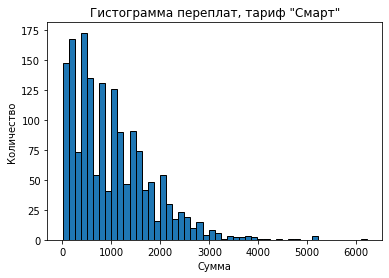

In [55]:
#Построим гистограмму "переплат" клиентов тарифа Смарт
title = 'Гистограмма переплат, тариф "Смарт"'
df_filtered = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                               (df_event_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
ax = df_filtered.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма переплат, тариф "Смарт"')
ax.set_xlabel('Сумма')
ax.set_ylabel('Количество')

Мы видим что довольно много переплат, с учетом того что тариф стоит 550 рублей

Text(0, 0.5, 'Количество')

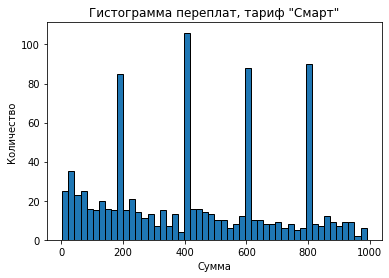

In [56]:
# Посмотрим на нее чуть ближе
df_filtered_less1000 = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                                        (df_event_numbers['Плата сверх лимита, руб.'] > 0) &
                                        (df_event_numbers['Плата сверх лимита, руб.'] < 1000)]['Плата сверх лимита, руб.']
ax = df_filtered_less1000.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма переплат, тариф "Смарт"')
ax.set_xlabel('Сумма')
ax.set_ylabel('Количество')

Ага, видим что довольно часто клиенты дозаказывали себе гигабайт интернета за 200 рублей, это позволяет сделать вывод, что **клиентам смарта не хватает количесва трафика интернета включенного в тариф**

Text(0, 0.5, 'Количество')

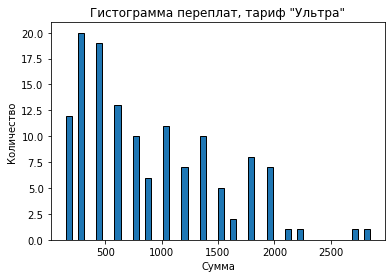

In [57]:
# Построим гистограмму "переплат" клиентов тарифа Ультра
df_filtered = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                               (df_event_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
ax = df_filtered.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма переплат, тариф "Ультра"')
ax.set_xlabel('Сумма')
ax.set_ylabel('Количество')

Переплаты также есть, в основном до 1500 рублей. Посмотрим ближе!

Text(0, 0.5, 'Количество')

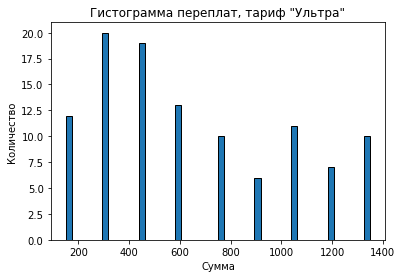

In [58]:
df_filtered_less1000 = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                                        (df_event_numbers['Плата сверх лимита, руб.'] > 0) &
                                        (df_event_numbers['Плата сверх лимита, руб.'] < 1500)]['Плата сверх лимита, руб.']
ax = df_filtered_less1000.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма переплат, тариф "Ультра"')
ax.set_xlabel('Сумма')
ax.set_ylabel('Количество')

Также видим, что **переплачивают по 150р. за дополнительный 1 Гб интернет-трафика различное количество раз!**

#### Услуги которые чаще дозаказывают пользователи каждого из тарифов

In [59]:
(df_event_numbers.groupby('Тариф').sum()[['Минуты сверх', 'СМС сверх', 'Мб сверх']]).reset_index()

,Тариф,Минуты сверх,СМС сверх,Мб сверх
0,smart,92739.0,12928,6175667.0
1,ultra,0.0,0,743233.0


**Вывод** Пользователи тарифа Смарт доказывают услуги всех типов. Пользователи тарифа Ультра - только интернет.

#### Круговые диаграммы

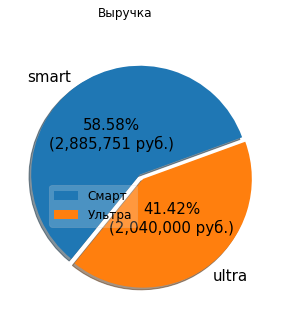

In [60]:
# Подсчитаем выручку за год по тарифам
all_revenue = df_event_numbers['Сумма за месяц, руб.'].sum()


def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')['Сумма за месяц, руб.'].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Выручка', pctdistance=0.45,
                                                                     startangle=20, figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.5,0.5), framealpha=0.2, prop={'size':12})
    ax.set_ylabel('')

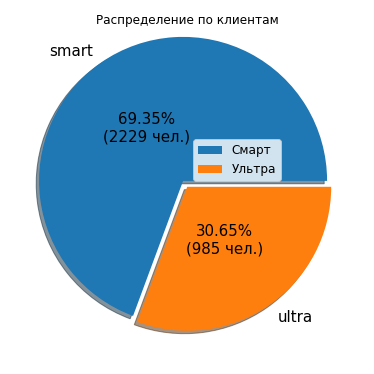

In [61]:
# Распределение клиентов по тарифвам
all_users = df_event_numbers['User_id'].count()


def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')['User_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Распределение по клиентам', pctdistance=0.45,
                                                                     figsize=(20,5), autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.5,0.5), prop={'size':12})
    ax.set_ylabel('')

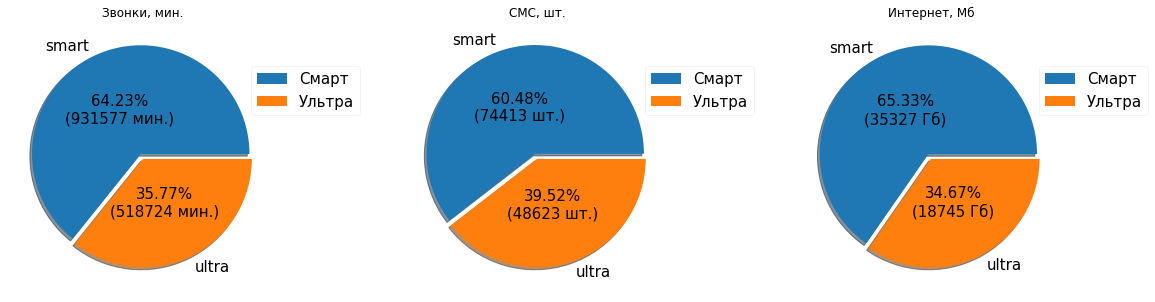

In [62]:
# Использование трафика по тарифам
columns_to_plot = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Мб']

calls_sum = df_event_numbers['Звонки, мин.'].sum()
sms_sum = df_event_numbers['СМС, шт.'].sum()
internet_sum = df_event_numbers['Интернет, Мб'].sum()

def func_pct(pct):
    if pct > 65 or pct < 35:
        sum_of_data = internet_sum
        value = float(pct/100.*sum_of_data/1024)
        metric = 'Гб'
    elif pct > 64 or pct < 36:
        sum_of_data = calls_sum
        value = float(pct/100.*sum_of_data)
        metric = 'мин.'
    else:
        sum_of_data = sms_sum
        value = float(pct/100.*sum_of_data)
        metric = 'шт.'
    return "{:.2f}%\n({:.0f} {})".format(pct, value, metric)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')[columns_to_plot].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                       use_index=False, shadow=True, explode=explode,
                                                                       title = columns_to_plot, pctdistance=0.45,
                                                                       autopct=lambda pct: func_pct(pct), figsize=(20,5))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], framealpha=0.2, bbox_to_anchor=(0.87,0.87), prop={'size':15})
    ax.set_ylabel('')

In [63]:
df_event_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб.",Не хватило тарифа
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0


count    2229.000000
mean       46.947510
std        21.039171
min         0.000000
25%        32.000000
50%        47.000000
75%        61.000000
max       162.000000
Name: Кол-во звонков, шт., dtype: float64

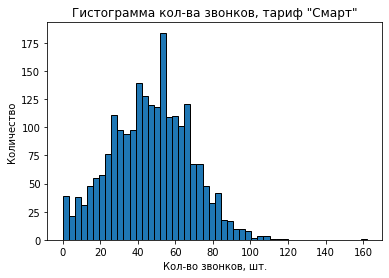

In [64]:
smart_call_hist = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                               (df_event_numbers['Кол-во звонков, шт.'] >= 0)]['Кол-во звонков, шт.']
ax = smart_call_hist.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма кол-ва звонков, тариф "Смарт"')
ax.set_xlabel('Кол-во звонков, шт.')
ax.set_ylabel('Количество')

smart_call_hist.describe()

count    985.000000
mean      59.236548
std       35.562722
min        0.000000
25%       33.000000
50%       58.000000
75%       84.000000
max      190.000000
Name: Кол-во звонков, шт., dtype: float64

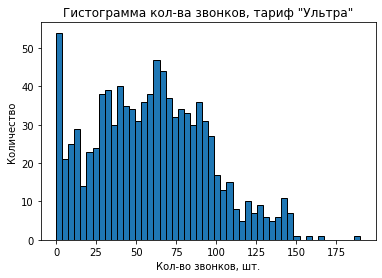

In [65]:
ultra_call_hist = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                               (df_event_numbers['Кол-во звонков, шт.'] >= 0)]['Кол-во звонков, шт.']
ax = ultra_call_hist.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма кол-ва звонков, тариф "Ультра"')
ax.set_xlabel('Кол-во звонков, шт.')
ax.set_ylabel('Количество')

ultra_call_hist.describe()

count    2229.000000
mean       46.947510
std        21.039171
min         0.000000
25%        32.000000
50%        47.000000
75%        61.000000
max       162.000000
Name: Кол-во звонков, шт., dtype: float64

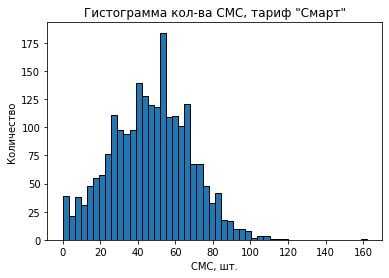

In [66]:
smart_sms_hist = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                               (df_event_numbers['СМС, шт.'] >= 0)]['Кол-во звонков, шт.']
ax = smart_call_hist.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма кол-ва СМС, тариф "Смарт"')
ax.set_xlabel('СМС, шт.')
ax.set_ylabel('Количество')

smart_sms_hist.describe()

count    985.000000
mean      59.236548
std       35.562722
min        0.000000
25%       33.000000
50%       58.000000
75%       84.000000
max      190.000000
Name: Кол-во звонков, шт., dtype: float64

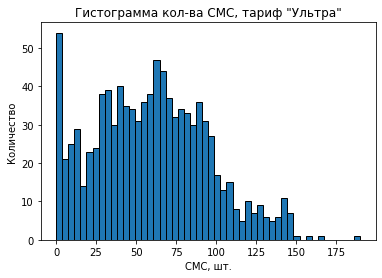

In [67]:
ultra_sms_hist = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                               (df_event_numbers['СМС, шт.'] >= 0)]['Кол-во звонков, шт.']
ax = ultra_call_hist.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма кол-ва СМС, тариф "Ультра"')
ax.set_xlabel('СМС, шт.')
ax.set_ylabel('Количество')

ultra_sms_hist.describe()

count    2229.000000
mean       46.947510
std        21.039171
min         0.000000
25%        32.000000
50%        47.000000
75%        61.000000
max       162.000000
Name: Кол-во звонков, шт., dtype: float64

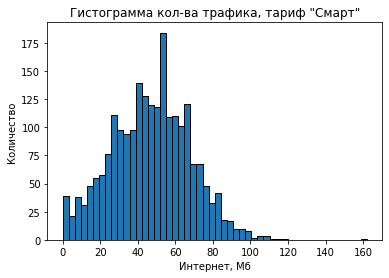

In [68]:
smart_internet_hist = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                               (df_event_numbers['Интернет, Мб'] >= 0)]['Кол-во звонков, шт.']
ax = smart_call_hist.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма кол-ва трафика, тариф "Смарт"')
ax.set_xlabel('Интернет, Мб')
ax.set_ylabel('Количество')

smart_internet_hist.describe()

count    985.000000
mean      59.236548
std       35.562722
min        0.000000
25%       33.000000
50%       58.000000
75%       84.000000
max      190.000000
Name: Кол-во звонков, шт., dtype: float64

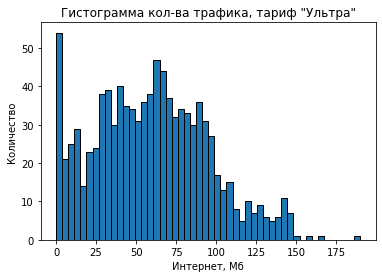

In [69]:
ultra_sms_hist = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                               (df_event_numbers['СМС, шт.'] >= 0)]['Кол-во звонков, шт.']
ax = ultra_call_hist.plot(kind='hist', title=title, ec='black', bins=50)
ax.set_title('Гистограмма кол-ва трафика, тариф "Ультра"')
ax.set_xlabel('Интернет, Мб')
ax.set_ylabel('Количество')

ultra_sms_hist.describe()

| Тариф         | Кол-во абонентов.  |      Звонки          |   СМС            | Интернет | Выручка |
|---------------|--------------------|--------------------- |------------------|---------|----------|
| Тариф "Смарт" |**69,3 %**	2229 чел.|**64,2 %** 931 577 мин|**60,5 %**	74413 шт. |**65,3 %**	35 327 Гб|**58,6 %**	2,89 млн руб.|
| Тариф "Ультра"| 30,7 %	985 чел. |35,8 % 518 724 мин    |39,5 %	48623 шт.     | 34,7 %	18 745 Гб|41,4 %	2,04 млн руб.|


**Вывод** Больше людей пользуются тарифом Смарт, больше трафика проходит через тариф Смарт, больше отправляется смс и больше совершается звонков, и, как следствие, большую часть выручки приносит тариф Смарт, даже несмотря на что, что абонентская плата по тарифу Ультра в 3 раза выше.

# Шаг 4. Проверка гипотез

## Проверка гипотезы, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Начнём с формулировки нулевой гипотезы. H₀ всегда формулируется так, чтобы использовать знак равенства. H₀ - среднее рассматриваемой генеральной совокупности равно второй. Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ - среднее генеральной совокупности не равно второй.

Критический уровень статистической значимости присвоим значением 0.05.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind.

In [70]:
sum_smart = df_event_numbers [(df_event_numbers['Тариф'] == 'smart') &
                                        (df_event_numbers['Сумма за месяц, руб.'].sum())]

In [71]:
sum_ultra = df_event_numbers [(df_event_numbers['Тариф'] == 'ultra') &
                                        (df_event_numbers['Сумма за месяц, руб.'].sum())]

In [72]:
smart = sum_smart['Сумма за месяц, руб.']
ultra = sum_ultra['Сумма за месяц, руб.']

print('cреднее Smart: ',pd.Series(smart).mean())
print('cреднее Ultra: ',pd.Series(ultra).mean())
alpha = .05

results = st.ttest_ind(
    smart, 
    ultra)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее Smart:  1294.6393001345896
cреднее Ultra:  2071.0659898477156
p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


Можем сказать, что выручка по двум тарифам сильно различается. Вернее, только исходя из проверки гипотезы мы не можем сказать, что больше, — только что количество выручки отличается. Потому что гипотеза-то наша двухсторонняя: мы не знаем, в какую сторону оно отличается. Однако посчитав среднее количество выручки для обоих тарифов, с уверенностью можем сказать: cредняя выручка из тарифа Ultra выше.

## Проверка гипотезы, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [73]:
df_event_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб.",Не хватило тарифа
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0


In [74]:
moscow_tariff = df_event_numbers[(df_event_numbers['Город'] == 'Москва')]

In [75]:
other_tariff = df_event_numbers[(df_event_numbers['Город'] != 'Москва')]

In [76]:
moscow = moscow_tariff['Сумма за месяц, руб.']
other = other_tariff['Сумма за месяц, руб.']

print('Выручка по Москве: ',pd.Series(moscow).mean())
print('Выручка с других регионов: ',pd.Series(other).mean())
alpha = 0.05

results = st.ttest_ind(
    moscow, 
    other) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Выручка по Москве:  1550.8052373158755
Выручка с других регионов:  1528.3169419900116
p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Можем сказать, что выручка по Москве и других регионам почти не различается. Вернее, только исходя из проверки гипотезы мы не можем сказать, что больше, — только что количество выручки почти одинаково и входит в диапазон статистической значимости. Потому что гипотеза-то наша двухсторонняя: мы не знаем, в какую сторону оно отличается. Однако посчитав среднее количество выручки для Москвы и других регионов, с уверенностью можем сказать: выручка не отличается существенно.

In [77]:
# Сохраним moscow_tariff_ultra список пользователей из Москвы с тарифом Ультра.
moscow_tariff_ultra = df_event_numbers[(df_event_numbers['Город'] == 'Москва') & (df_event_numbers['Тариф'] == 'ultra')]

In [78]:
# Сохраним other_tariff_ultra список пользователей из других регионов с тарифом Ультра.
other_tariff_ultra = df_event_numbers[(df_event_numbers['Город'] != 'Москва') & (df_event_numbers['Тариф'] == 'ultra')]

In [79]:
moscow = moscow_tariff_ultra['Сумма за месяц, руб.']
other = other_tariff_ultra['Сумма за месяц, руб.']

print('Выручка по Москве тарифа Ultra: ',pd.Series(moscow).mean())
print('Выручка с других регионов тарифа Ultra: ',pd.Series(other).mean())
alpha = 0.05

results = st.ttest_ind(
    moscow, 
    other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Выручка по Москве тарифа Ultra:  2075.3333333333335
Выручка с других регионов тарифа Ultra:  2069.8026315789475
p-значение: 0.8475623384854951
Не получилось отвергнуть нулевую гипотезу


Можем сказать, что выручка по Москве и других регионам, по тарифу Ультра, почти не различается. Вернее, только исходя из проверки гипотезы мы не можем сказать, что больше, — только что количество выручки почти одинаково и входит в диапазон статистической значимости. Потому что гипотеза-то наша двухсторонняя: мы не знаем, в какую сторону оно отличается. Однако посчитав среднее количество выручки для Москвы и других регионов, с уверенностью можем сказать: выручка не отличается существенно.

In [80]:
moscow_tariff_smart = df_event_numbers[(df_event_numbers['Город'] == 'Москва') & (df_event_numbers['Тариф'] == 'smart')]

In [81]:
other_tariff_smart = df_event_numbers[(df_event_numbers['Город'] != 'Москва') & (df_event_numbers['Тариф'] == 'smart')]

In [82]:
moscow = moscow_tariff_smart['Сумма за месяц, руб.']
other = other_tariff_smart['Сумма за месяц, руб.']

print('cреднее до: ',pd.Series(moscow).mean())
print('cреднее после: ',pd.Series(other).mean())
alpha = 0.05

results = st.ttest_ind(
    moscow, 
    other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее до:  1245.0569948186528
cреднее после:  1305.0238741182854
p-значение: 0.19196326570657848
Не получилось отвергнуть нулевую гипотезу


Можем сказать, что выручка по Москве и других регионам, по тарифу Смарт, почти не различается. Вернее, только исходя из проверки гипотезы мы не можем сказать, что больше, — только что количество выручки почти одинаково и входит в диапазон статистической значимости. Потому что гипотеза-то наша двухсторонняя: мы не знаем, в какую сторону оно отличается. Однако посчитав среднее количество выручки для Москвы и других регионов, с уверенностью можем сказать: выручка не отличается существенно.

# Общие выводы

### Cоберем общие данные по тарифам по части использования включенных в абонентскую плату лимитов и по части дозаказываемых (пакетов) услуг

In [83]:
smart_mean_internet = (df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Интернет, Мб']/(1024 * 15)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Смарт" - {:.2%} = {:,.0f} Гб'.
      format(smart_mean_internet, smart_mean_internet * 1024 * 15))
smart_mean_calls = (df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Звонки, мин.']/(500)).mean()
print('Средний процент использования пакета минут по тарифу "Смарт" - {:.2%} = {:.2f} мин'.
      format(smart_mean_calls, smart_mean_calls * 500))
smart_mean_sms = (df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['СМС, шт.']/(50)).mean()
print('Средний процент использования пакета СМС по тарифу "Смарт" - {:.2%} = {:.0f} шт.'.
      format(smart_mean_sms, smart_mean_sms * 50))
print('---------------------------------------------------------------------------------')
ultra_mean_internet = (df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Интернет, Мб']/(1024 * 30)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Ультра" - {:.2%} = {:,.0f} Гб'.
      format(ultra_mean_internet, ultra_mean_internet * 1024 * 30))
ultra_mean_calls = (df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Звонки, мин.']/(3000)).mean()
print('Средний процент использования пакета минут по тарифу "Ультра" - {:.2%} = {:.2f} мин'.
      format(ultra_mean_calls, ultra_mean_calls * 3000))
ultra_mean_sms = (df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['СМС, шт.']/(1000)).mean()
print('Средний процент использования пакета СМС по тарифу "Ультра" - {:.2%} = {:.0f} шт.'.
      format(ultra_mean_sms, ultra_mean_sms * 1000))

Средний процент использования пакета интернет-трафика по тарифу "Смарт" - 105.66% = 16,229 Гб
Средний процент использования пакета минут по тарифу "Смарт" - 83.59% = 417.93 мин
Средний процент использования пакета СМС по тарифу "Смарт" - 66.77% = 33 шт.
---------------------------------------------------------------------------------
Средний процент использования пакета интернет-трафика по тарифу "Ультра" - 63.43% = 19,487 Гб
Средний процент использования пакета минут по тарифу "Ультра" - 17.55% = 526.62 мин
Средний процент использования пакета СМС по тарифу "Ультра" - 4.94% = 49 шт.


### Информация по самим переплатам

In [84]:
smart_over_mean_internet = df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Мб сверх'].mean()
smart_over_mean_internet_rub = np.round(smart_over_mean_internet, -3)/1000 * 200
print('Среднее превышение пакета интернет по тарифу "Смарт" - {:.0f} Мб на сумму - {:.0f} руб.'.
      format(smart_over_mean_internet, smart_over_mean_internet_rub))

smart_over_mean_calls = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Минуты сверх'].mean())
smart_over_mean_calls_rub = smart_over_mean_calls * 3
print('Среднее превышение пакета минут по тарифу "Смарт" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(smart_over_mean_calls, smart_over_mean_calls_rub))

smart_over_mean_sms = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['СМС сверх'].mean())
smart_over_mean_sms_rub = smart_over_mean_sms * 3
print('Среднее превышение пакета СМС по тарифу "Смарт" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(smart_over_mean_sms, smart_over_mean_sms_rub))

print('----------------------------------------------------------------')

ultra_over_mean_internet = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Мб сверх'].mean()
ultra_over_mean_internet_rub = np.round(ultra_over_mean_internet, -3)/1000 * 150
print('Среднее превышение пакета интернет по тарифу "Ультра" - {:.0f} Мб на сумму - {:.0f} руб.'.
      format(ultra_over_mean_internet, ultra_over_mean_internet_rub))

ultra_over_mean_calls = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Минуты сверх'].mean())
ultra_over_mean_calls_rub = ultra_over_mean_calls * 3
print('Среднее превышение пакета минут по тарифу "Ультра" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(ultra_over_mean_calls, ultra_over_mean_calls_rub))

ultra_over_mean_sms = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['СМС сверх'].mean())
ultra_over_mean_sms_rub = ultra_over_mean_sms * 3
print('Среднее превышение пакета СМС по тарифу "Ультра" - {:.0f} шт. на сумму - {:.0f} руб.')

Среднее превышение пакета интернет по тарифу "Смарт" - 2771 Мб на сумму - 600 руб.
Среднее превышение пакета минут по тарифу "Смарт" - 42 мин на сумму - 126 руб.
Среднее превышение пакета СМС по тарифу "Смарт" - 6 шт. на сумму - 18 руб.
----------------------------------------------------------------
Среднее превышение пакета интернет по тарифу "Ультра" - 755 Мб на сумму - 150 руб.
Среднее превышение пакета минут по тарифу "Ультра" - 0 мин на сумму - 0 руб.
Среднее превышение пакета СМС по тарифу "Ультра" - {:.0f} шт. на сумму - {:.0f} руб.


### Выводы

- Пользователи больше предпочитают тариф Smart.
- Больше всего приносит дополнительного дохода тариф Smart.
- Самым прибильным сегментом является - интернет, при том в двух тарифах.
- Общая прибыль больше всего у тарифа Smart.
- Пользователи тарифа Smart часто не вклиниваются в лимиты, чаще всего по кол-ству минут и очень много по лимиту мегабайт.
- Пользователи тарифа Ultra практически не превышают лимитов, кроме мегабайт интернета.
- Пользователи двух тарифов используют примерно одинаковые объемы интернета, особенно на пиках графиков.
- В двух тарифак довольно много либо не пользуются отправкой сообщений, либо же используют в небольших кол-ствах до 5-10 сообщений.
- Пользователи тарифа Ultra чаще всего не используют весь лимит по звонкам и сообщениям.
- Несмотря на то, что больше прибыли приносит тариф Smart, среднняя выручка выше у Ultra.
- Разница в средней вырчки из Москвы и других регонов - незначительная, это относится и к сравнению тарифов по Москве и регионам.

Тариф Смарт приносит около 60% всей выручки, но при этом на него приходится 2200 пользователей. Тариф Ультра дает остальные 40%, но эту выручку генерируют всего 1000 пользователей.
Среднему пользователю тарифа Смарт не хватает 2 Гб интернета к заложенными в абонентскую плату 15 Гб и ему приходится дозаказывать эти 2 Гб и доплачивать за них 400 рублей.
Если рассматривать только тех пользователей Смарт, кто вылезает за лимиты по интернет-трафику, то средний размер доп. заказа интернет-трафика равен 3 Гб, за которые они платят 600 рублей.

Таким образом, в тарифной сетке есть дешевый тариф Смарт за 550 рублей, где пользователю не хватает интернета и количество использованных минут разговора на грани лимита (418 мин из 500), и есть тариф Ультра, стоимостью 1950 рублей, которым пользуется уже другой класс граждан, где лимитов по всем типам связи предостаточно (иногда дозаказывают в среднем 1 Гб интернета).

### Рекомендации


Проведя анализ можно сделать рекомендации компании "Мегалайн". Им нужно подумать и выработать промежуточное решение, которое позволяло бы клиенту более комфортно, без доп. заказов, пользоваться услугами связи (особенно мобильным интернетом), при этом по цене являлось бы промежуточным вариантом между текущими Смарт и Ультра. **Учитывая то, что средний пользователь тарифа Смарт дозаказывает 2 Гб на 400 рублей, т.е. платит в итоге 550 + 400 = 950 рублей за месяц, это значит, что эти деньги клиент готов тратить в месяц в качестве абонентской платы.** Например, можно рассмотреть вариант **создания тарифа, в дополнение к текущим, под названием "СмартПлюс"**, который был бы создан на основе тарифа Смарт, но с пакетом интернет-трафика в 20 Гб и стоимостью 950 рублей. Для большего привлечения внимания к тарифу можно расширить пакет минут и пакет СМС. Компания в плане выручки не потеряет, т.к. средний пользователь не дозаказывает эти услуги, но при этом заставит выглядеть предложение выгодней!